# Домашнее задание по сопряженным градиентам

##### Выполнил: АРТЁМ АГАФОНОВ

В этом задании Вам предлагается рассмотреть как влияют предобуславливатели на время работы метода сопряженных градиентов.

Рассмотрим задачу минимизации квадратичной формы:

$$f(x) = \frac{1}{2}||Ax-b||^2_2=\frac{1}{2}\sum\limits_{i=1}^n(a_i^Tx-b_i)^2$$

где $A\in \mathbb{S}^{n}_{++}$, $b \in \mathbb{R}^{n}$.

Как мы знаем, эта задача выпукла и минимум находится из условия $\nabla f(x^*) =Ax^*-b= 0$. То есть для решения задачи необходимо разрешить систему уравнений $Ax=b$. Можно просто применить метод сопряженных градиентов, но если матрица плохо обусловлена ($\frac{\lambda_{max}}{\lambda_{min}}>>1$), метод работает очень медленно. Один из способов борьбы с этим - использование матриц-предобуславливателей разных видов и последующее решение одной из задач:

$$M^{-1}A x = M^{-1}b$$

$$M^TAM y = M^Tb$$ где $y = M^{-1}x.$

Существует несколько довольно простых, но зачастую сильно улучшающих работу метода **предоубславливателей**:


* M = diag($A_{11},A_{22}...A_{nn}$) (Jacobi)

* M $\approx \hat A$, где например $\hat A$ - неполная [факторизация](http://www.math.iit.edu/~fass/477577_Chapter_16.pdf) Холецкого


Факторизация Холецкого s.p.d. матрицы A - ее разложение на произведение нижнетреугольной и верхнетреугольной матрицы: $A = L^TL$ [wiki](https://en.wikipedia.org/wiki/Cholesky_decomposition).  Есть несколько упрощений этого алгоритма, позволяющих получить матрицу, "похожую" на A. Мы будем использовать следующую:  $if \quad (a_{i,j} =0) \rightarrow l_{i,j} = 0$, а далее по алгоритму.

$\textbf{Задание}$ Выбрать 1 задачу [отсюда](https://sparse.tamu.edu/), исследовать как влияет на скорость сходимости тот или иной предоубславливатель:

1) Сравнить число итераций, за которое метод сходится с точностью $10^{-7}$ для двух предобуславливателей и для обычного метода сопряженных градиентов.

2) Построить графики зависимости ошибки $\dfrac{x_{k-1}-x_{k}}{x_k}$ от номера итерации для двух предобуславливателей и для обычного метода сопряженных градиентов.

Пример:

![alt text](https://pp.userapi.com/c831309/v831309597/108727/JXO7HGHv8r4.jpg)

In [388]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io as spio
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

In [389]:
mat = spio.mmread('/Users/artemavdeev/Documents/учеба/3_course/6_sem/opt/hw5/685_bus.mtx')
mat = scipy.sparse.csc_matrix(mat)
mat = mat.todense()
mat = np.array(mat)
print(mat)

[[26185.5         0.          0.      ...     0.          0.
      0.     ]
 [    0.        539.2913   -303.0303  ...     0.          0.
      0.     ]
 [    0.       -303.0303    515.985   ...     0.          0.
      0.     ]
 ...
 [    0.          0.          0.      ...    54.98211     0.
      0.     ]
 [    0.          0.          0.      ...     0.         60.43118
      0.     ]
 [    0.          0.          0.      ...     0.          0.
    163.9344 ]]


In [390]:
def diag(A):
    return np.diag(np.diag(A))

def cholesky(A):
    n = A.shape[0]
    L = np.zeros((A.shape[0], A.shape[1]))
    for j in range(n):
        if A[j, j] == 0:
            L[j, j] = 0
        else:
            L[j, j] = np.sqrt(A[j, j] - np.sum(L[j, :]**2))
            for i in range(j + 1, n):
                if A[i, j] == 0:
                    L[i, j] = 0
                else:
                    L[i, j] = (A[i, j] - np.sum(L[i] * L[j])) / L[j, j]
            
    return L @ np.transpose(L)

In [397]:
def conj_quad(A, b, x0, eps = 1e-8):
    
    def grad(x):
        g = - np.dot(A, x) + b
        return g
    
    g = grad(x0)
    x = [x0]
    d = - g
    loss = []
    
    while np.linalg.norm(grad(x[-1])) > eps:
        
        alpha = - np.transpose(d) @ (A @ x[-1] - b) / (np.transpose(d) @ A @ d)
        x.append(x[-1] + alpha * d)
        
        loss.append(np.linalg.norm((x[-2] - x[-1])/x[-1]))
        
        beta = np.transpose(grad(x[-1])) @ A @ d / (np.transpose(d) @ A @ d)
        d = - grad(x[-1]) + beta * d
        
    return x, loss

In [398]:
def precond(A, b, L):
    A = np.linalg.inv(L) @ A
    b = np.linalg.inv(L) @ b
    return A, b

In [399]:
b =  np.random.normal(np.mean(mat), 2, mat.shape[0])
x0 = np.random.normal(np.mean(mat), 2, mat.shape[0])

x = conj_quad(mat, b ,x0)

A_ch, b_ch = precond(mat, b, cholesky(mat))
x_ch = conj_quad(A_ch, b_ch ,x0)

A_diag, b_diag = precond(mat, b, diag(mat))
x_diag = conj_quad(A_diag, b_diag ,x0)

In [405]:
print('ITERATIONS:')
print ('No precounter:', len(x[1]))
print ('Jacobi:', len(x_diag[1]))
print ('Cholesky:', len(x_ch[1]))

ITERATIONS:
No precounter: 834
Jacobi: 1584
Cholesky: 365


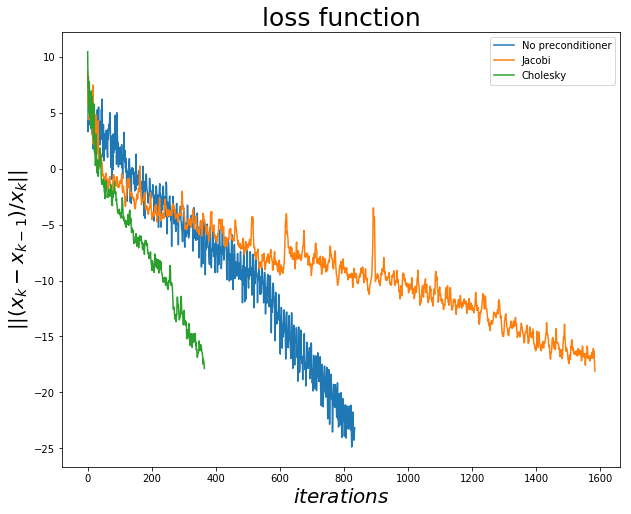

In [406]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(x[1])), np.log(x[1]), label = 'No preconditioner')
plt.plot(np.arange(len(x_diag[1])), np.log(x_diag[1]), label = 'Jacobi')
plt.plot(np.arange(len(x_ch[1])), np.log(x_ch[1]), label = 'Cholesky')
plt.title('loss function', fontsize = 25)
plt.xlabel('$iterations$', fontsize = 20)
plt.ylabel('$||(x_k - x_{k-1})/x_k ||$',  fontsize = 20)
plt.legend()

Видим, что сопряженный градиенты с предобуславливателем Якоби сходятся медленнее, чем градиенты без предобуславливателя. На [википедии](https://en.wikipedia.org/wiki/Preconditioner#Jacobi_(or_diagonal)_preconditioner) написано, что Якоби улучшает скорость сходимости для диагонально преобладающих матриц. Проверим, является ли наша матрица диагонально преобладающей.

In [401]:
def diag_dominant(X):
    D = np.diag(np.abs(X)) # Find diagonal coefficients
    S = np.sum(np.abs(X), axis=1) - D # Find row sum without diagonal
    if np.all(D > S):
        print ('matrix is diagonally dominant')
    else:
        print ('matrix is NOT diagonally dominant')
    return 0

In [402]:
print (diag_dominant(mat))

matrix is NOT diagonally dominant
0


Как видим, наша матрица не диагонально преобладающая. Значит, это вполне нормально, что предобуславлеватель Якоби не улучшает работу метода сопряженных градиентов.